<a href="https://colab.research.google.com/github/YasminaNasser/sattelite_images-segmentation/blob/main/Copy_of_Seg_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
!pip install tifffile


In [2]:
!pip install rasterio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 56.8 MB/s eta 0:00:00


In [37]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import os
import pandas as pd
import cv2
import os
import rasterio
from tensorflow.keras.metrics import Precision, Recall, MeanIoU, F1Score
import tifffile
from tensorflow.keras.utils import Sequence
import random



In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
train_img_dir = "/content/drive/MyDrive/Cellula internship/floods/satalite data/data/images"
train_mask_dir = "/content/drive/MyDrive/Cellula internship/floods/satalite data/data/labels"

In [6]:
def display_image_and_mask(img_path, mask_path):
    with rasterio.open(img_path) as src:
        img = src.read()

    if img.shape[0] >= 3:
        rgb = np.stack([img[2], img[1], img[0]], axis=-1)  # (H, W, 3)
        rgb = (rgb - np.min(rgb)) / (np.max(rgb) - np.min(rgb))
    else:
        rgb = img[0]


    mask = np.array(Image.open(mask_path))


    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].imshow(rgb)
    ax[0].set_title("Image (RGB composite)")
    ax[0].axis('off')

    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title("Mask")
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()


In [7]:
import os
import shutil
import re

output_images = "/content/drive/MyDrive/Cellula internship/floods/final_images"
output_labels = "/content/drive/MyDrive/Cellula internship/floods/final_mask"

os.makedirs(output_images, exist_ok=True)
os.makedirs(output_labels, exist_ok=True)

def extract_number(filename):
    match = re.match(r"^(\d+)", filename)
    return match.group(1) if match else None

images = {}
for f in os.listdir(train_img_dir):
    if f.lower().endswith(".tif"):
        num = extract_number(f)
        if num:
            images[num] = f

masks = {}
for f in os.listdir(train_mask_dir):
    if f.lower().endswith(".png"):
        num = extract_number(f)
        if num:
            masks[num] = f

matched_numbers = sorted(set(images.keys()) & set(masks.keys()))

print(f"Found {len(matched_numbers)} matching pairs.")
if len(matched_numbers) == 0:
    print("No matches found! Check filenames.")
    exit()

for num in matched_numbers:
    img_file = images[num]
    mask_file = masks[num]
    shutil.copy(os.path.join(train_img_dir, img_file), os.path.join(output_images, img_file))
    shutil.copy(os.path.join(train_mask_dir, mask_file), os.path.join(output_labels, mask_file))

print(f"Copied {len(matched_numbers)} pairs into '{output_images}' and '{output_labels}'.")


Found 306 matching pairs.
Copied 306 pairs into '/content/drive/MyDrive/Cellula internship/floods/final_images' and '/content/drive/MyDrive/Cellula internship/floods/final_mask'.


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


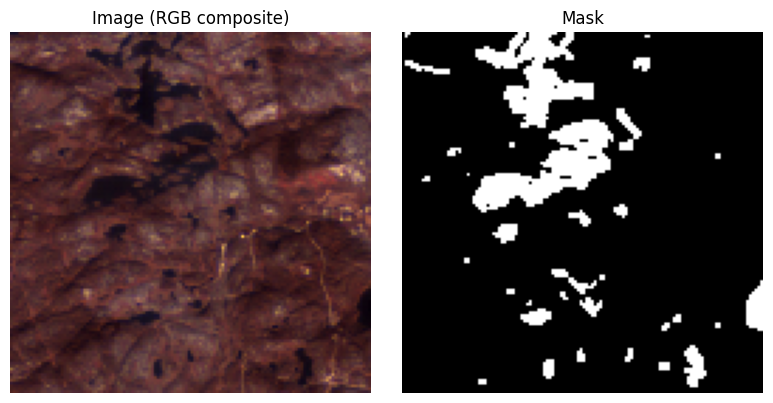

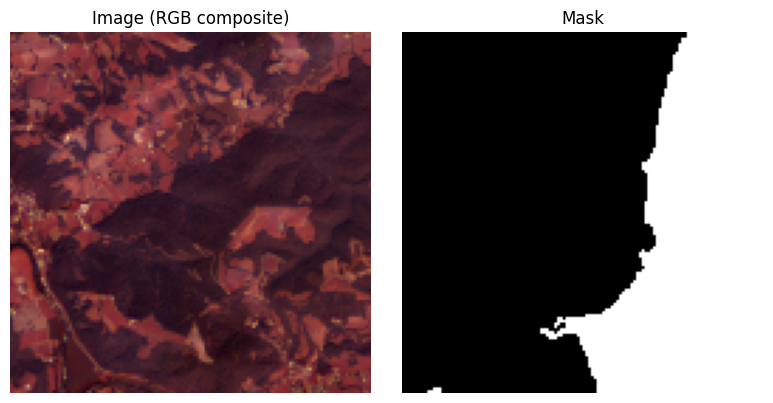

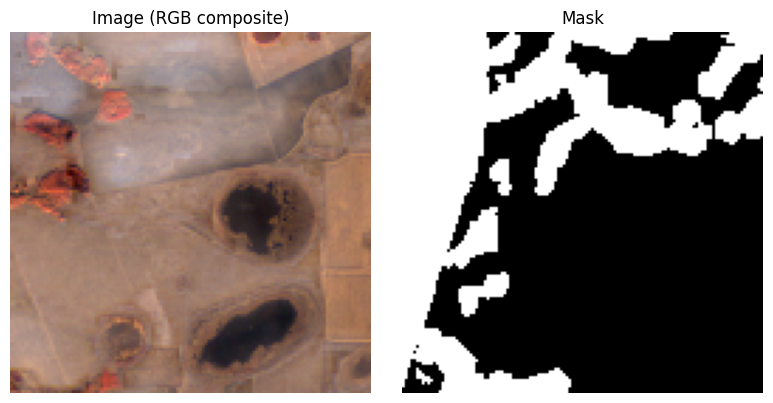

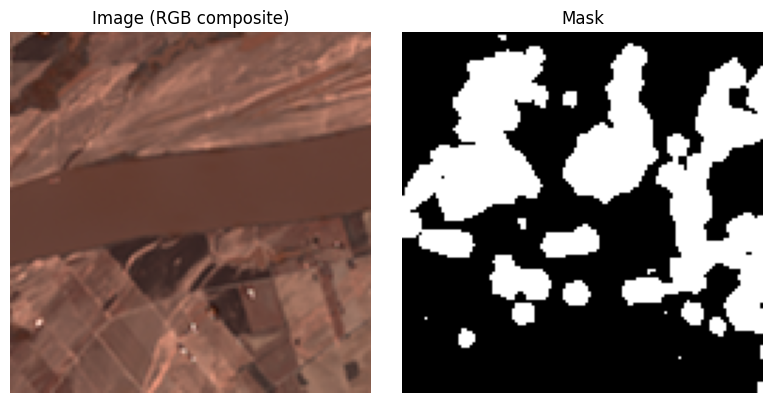

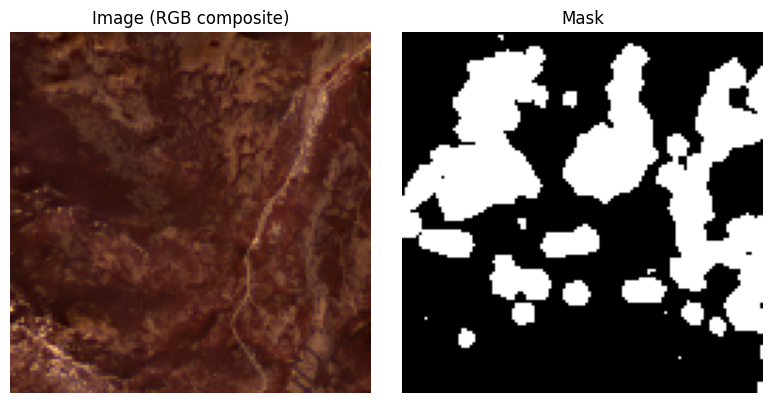

In [8]:
# Get image and mask filenames and sort them to ensure matching
train_img_files = sorted(os.listdir(output_images))
train_mask_files = sorted(os.listdir(output_labels))

# Check that the number of images matches the number of masks
if len(train_img_files) != len(train_mask_files):
    print("Error: The number of images and masks do not match!")
else:
    # Display only the first 5 image-mask pairs
    for img_file, mask_file in zip(train_img_files[:5], train_mask_files[:5]):
        # Construct the full file paths
        img_path = os.path.join(output_images, img_file)
        mask_path = os.path.join(output_labels, mask_file)

        # Display the image and mask together
        display_image_and_mask(img_path, mask_path)

In [9]:
len(train_img_files)

306

In [10]:
len(train_mask_files)

306

In [11]:
# Normalize single band for display
def normalize_band(band):
    band = band.astype(np.float32)
    return (band - np.min(band)) / (np.max(band) - np.min(band) + 1e-8)

# Load multi-band .tif
def load_multiband_tif(tif_path):
    img = tifffile.imread(tif_path)
    if img.shape[0] == 12:  # (12, H, W)
        img = np.transpose(img, (1, 2, 0))
    return img

# Load binary mask
def load_mask(mask_path, size=None):
    mask = np.array(Image.open(mask_path))
    if size is not None:
        mask = np.array(Image.fromarray(mask).resize(size, Image.NEAREST))
    return (mask > 0).astype(np.uint8)

# Plot all bands
def plot_all_bands(img, band_names=None):
    h, w, c = img.shape
    if band_names is None:
        band_names = [f"Band {i}" for i in range(c)]

    plt.figure(figsize=(12, 10))
    for i in range(c):
        plt.subplot(4, 3, i + 1)
        plt.imshow(normalize_band(img[..., i]), cmap='gray')
        plt.title(band_names[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Plot composites with mask overlay
def plot_composites(img, mask=None):
    rgb = img[..., [3, 2, 1]]  # Red, Green, Blue
    rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-8)

    false_color = img[..., [5, 4, 3]]  # SWIR1, NIR, Red
    false_color = (false_color - false_color.min()) / (false_color.max() - false_color.min() + 1e-8)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(rgb)
    if mask is not None:
        plt.imshow(np.ma.masked_where(mask == 0, mask), cmap='Reds', alpha=0.4)
    plt.title("RGB Composite")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(false_color)
    if mask is not None:
        plt.imshow(np.ma.masked_where(mask == 0, mask), cmap='Reds', alpha=0.4)
    plt.title("False Color (SWIR1-NIR-Red)")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


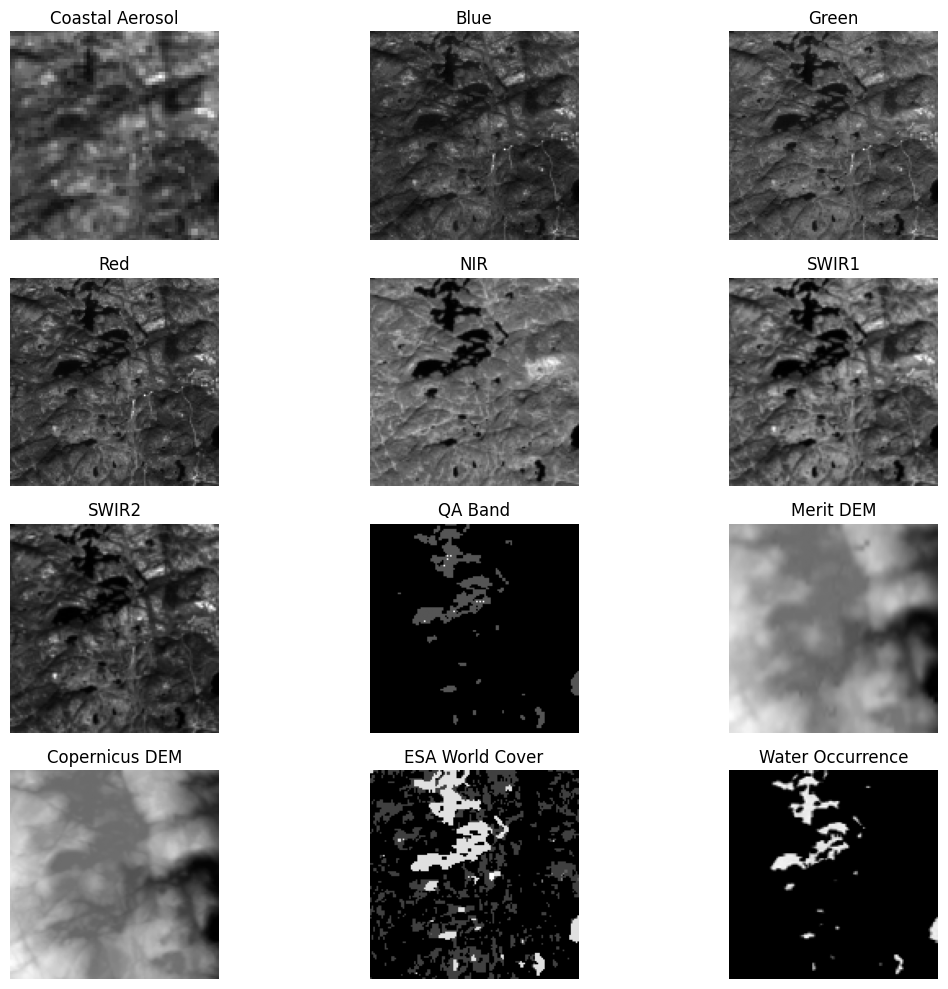

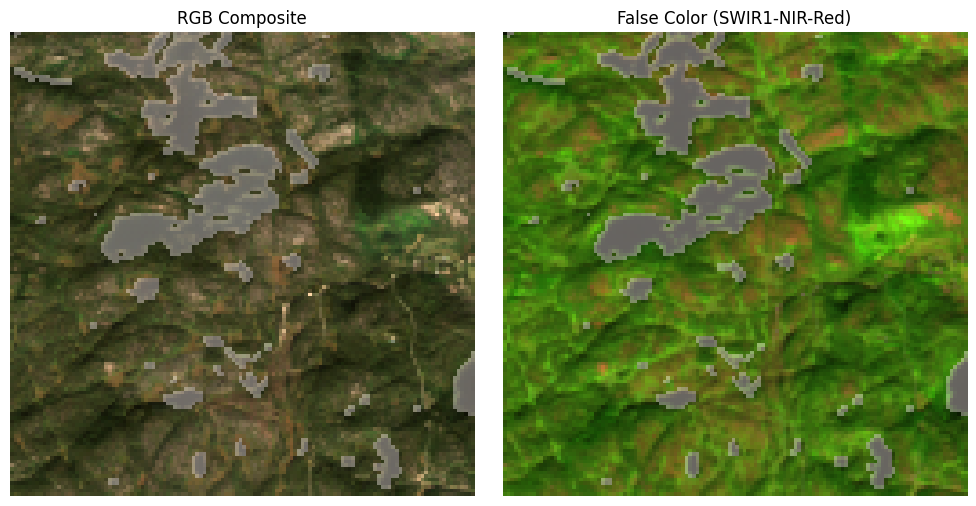

In [12]:
# Update paths
tif_path = "/content/drive/MyDrive/Cellula internship/floods/final_images/0.tif"
mask_path = "/content/drive/MyDrive/Cellula internship/floods/final_mask/0.png"

band_names = [
    "Coastal Aerosol", "Blue", "Green", "Red", "NIR",
    "SWIR1", "SWIR2", "QA Band", "Merit DEM", "Copernicus DEM",
    "ESA World Cover", "Water Occurrence"
]

img = load_multiband_tif(tif_path)
mask = load_mask(mask_path, size=img.shape[:2])

# Plot all bands
plot_all_bands(img, band_names)

# Plot RGB + False Color composites
plot_composites(img, mask)


# New

In [35]:
class MultiBandDataGenerator(Sequence):
    def __init__(self, dataframe, batch_size=16, img_size=(128, 128), shuffle=True, augment=False):
        self.df = dataframe.reset_index(drop=True)
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.augment = augment
        self.indices = np.arange(len(self.df))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_imgs = []
        batch_masks = []

        for i in batch_indices:
            img_path = self.df.loc[i, "image"]
            mask_path = self.df.loc[i, "mask"]

            # Load 12-band TIFF
            img = tifffile.imread(img_path).astype(np.float32)
            if img.shape[0] == 12:
                img = np.transpose(img, (1, 2, 0))  # (H, W, 12)

            # Band-wise normalization
            for b in range(img.shape[-1]):
                band = img[..., b]
                min_val, max_val = band.min(), band.max()
                img[..., b] = (band - min_val) / (max_val - min_val + 1e-8) if max_val > min_val else 0

            # Load mask
            mask = np.array(Image.open(mask_path))
            mask = (mask > 0).astype(np.float32)[..., np.newaxis]

            # Resize both
            if img.shape[:2] != self.img_size:
                img = np.array(Image.fromarray((img * 255).astype(np.uint8)).resize(self.img_size, Image.BILINEAR)) / 255.0
                mask = np.array(Image.fromarray(mask.squeeze().astype(np.uint8)).resize(self.img_size, Image.NEAREST))
                mask = mask[..., np.newaxis].astype(np.float32)

            # Apply data augmentation
            if self.augment:
                img, mask = self.apply_augmentation(img, mask)

            batch_imgs.append(img)
            batch_masks.append(mask)

        return np.array(batch_imgs), np.array(batch_masks)

    def apply_augmentation(self, img, mask):
        # Random horizontal flip
        if random.random() > 0.5:
            img = np.flip(img, axis=1)
            mask = np.flip(mask, axis=1)

        # Random vertical flip
        if random.random() > 0.5:
            img = np.flip(img, axis=0)
            mask = np.flip(mask, axis=0)

        # Random 90-degree rotations
        k = random.choice([0, 1, 2, 3])
        if k > 0:
            img = np.rot90(img, k, axes=(0, 1))
            mask = np.rot90(mask, k, axes=(0, 1))

        # Random brightness scaling (per band)
        if random.random() > 0.5:
            scale = 0.9 + random.random() * 0.2  # between 0.9 and 1.1
            img = np.clip(img * scale, 0, 1)

        return img, mask



In [38]:
# Create DataFrame with paths
images = [os.path.join(output_images, file) for file in os.listdir(output_images)]
masks = [os.path.join(output_labels, file) for file in os.listdir(output_labels)]
data = pd.DataFrame({"image": images, "mask": masks})

# Split
train_df, val_df = train_test_split(data, train_size=0.7, random_state=123, shuffle=True)

# Create generators
train_generator = MultiBandDataGenerator(train_df, batch_size=16, img_size=(128, 128), shuffle=True, augment=True)
val_generator = MultiBandDataGenerator(val_df, batch_size=16, img_size=(128, 128), shuffle=False, augment=False)

# Test shapes
X_batch, Y_batch = train_generator[0]
print(X_batch.shape)  # (16, 128, 128, 12)
print(Y_batch.shape)  # (16, 128, 128, 1)


(16, 128, 128, 12)
(16, 128, 128, 1)


In [39]:
def unet_model(input_size=(128, 128, 12)):
    inputs = Input(input_size)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)


    # Decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    # Output layer
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

In [40]:
def iou_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return intersection / (union + 1e-8)


In [41]:
model = unet_model(input_size=(128, 128, 12))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', iou_metric, Precision(name='precision'), Recall(name='recall')])
model.summary()

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_95 (Conv2D)  │ (None, 128, 128,  │      6,976 │ input_layer_5[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_96 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_95[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_20    │ (None, 64, 64,    │          0 │ conv2d_96[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_97 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_20… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_98 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_97[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_21    │ (None, 32, 32,    │          0 │ conv2d_98[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_99 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_21… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_100 (Conv2D) │ (None, 32, 32,    │    590,080 │ conv2d_99[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_22    │ (None, 16, 16,    │          0 │ conv2d_100[0][0]  │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_101 (Conv2D) │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_22… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_102 (Conv2D) │ (None, 16, 16,    │  2,359,808 │ conv2d_101[0][0]  │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_23    │ (None, 8, 8, 512) │          0 │ conv2d_102[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_103 (Conv2D) │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_23… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_104 (Conv2D) │ (None, 8, 8,      │  9,438,208 │ conv2d_103[0][0]  │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_20 │ (None, 16, 16,    │  2,097,664 │ conv2d_104[0][0]  │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_20      │ (None, 16, 16,    │          0 │ conv2d_transpose

 Total params: 31,036,929 (118.40 MB)

 Trainable params: 31,036,929 (118.40 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_198']
Received: inputs=Tensor(shape=(None, 128, 128, 12))
  warnings.warn(msg)


14/14 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.6761 - iou_metric: 0.1835 - loss: 0.6431 - precision: 0.6959 - recall: 0.2167 - val_accuracy: 0.6679 - val_iou_metric: 0.2679 - val_loss: 0.6438 - val_precision: 0.6522 - val_recall: 0.3241
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 285ms/step - accuracy: 0.7074 - iou_metric: 0.2815 - loss: 0.6138 - precision: 0.7122 - recall: 0.3414 - val_accuracy: 0.6679 - val_iou_metric: 0.2726 - val_loss: 0.6355 - val_precision: 0.6471 - val_recall: 0.3326
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - accuracy: 0.7239 - iou_metric: 0.3405 - loss: 0.5896 - precision: 0.7671 - recall: 0.3831 - val_accuracy: 0.6695 - val_iou_metric: 0.2683 - val_loss: 0.6327 - val_precision: 0.6578 - val_recall: 0.3238
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 284ms/step - accuracy: 0.7048 - iou_metric: 0.2610 - loss: 0.6086 - precision: 0.6635 - recall: 0.2957 - val_accuracy: 0.6698 - val_iou_metric: 0.2748 - val_loss: 0.6558 - val_precision: 0.6521 - val_reca

In [47]:
loss, accuracy, iou,percision,recall = model.evaluate(val_generator)
print(f'Validation Loss: {loss:.4f}')
print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Validation IoU: {iou:.4f}')
print(f'Validation Precision: {percision:.4f}')
print(f'Validation Recall: {recall:.4f}')


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.6883 - iou_metric: 0.2598 - loss: 0.6233 - precision: 0.6431 - recall: 0.3159
Validation Loss: 0.6420
Validation Accuracy: 0.6713
Validation IoU: 0.2821
Validation Precision: 0.6505
Validation Recall: 0.3457


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


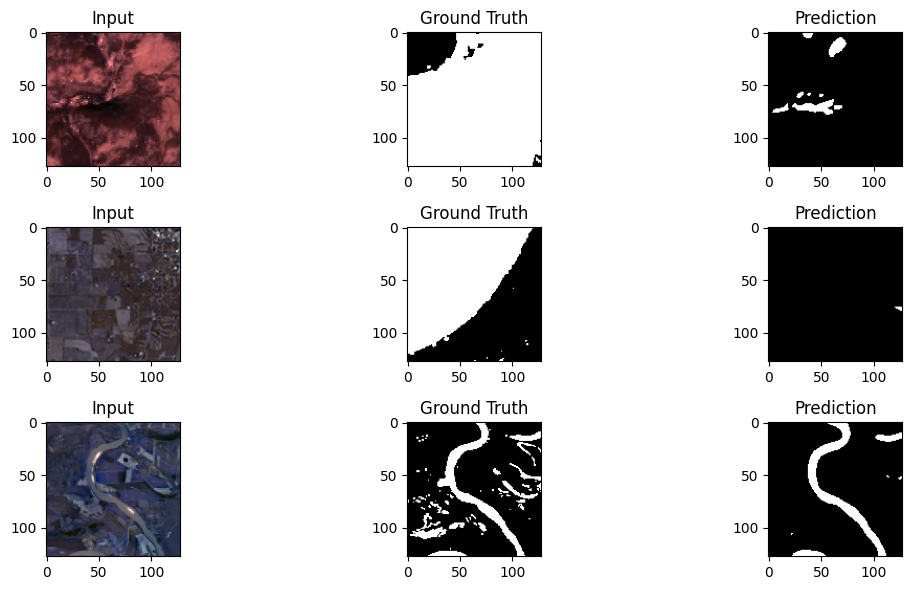

In [46]:
X_val, Y_val = val_generator[4]  # Get first batch
preds = model.predict(X_val)

plt.figure(figsize=(12, 6))
for i in range(3):  # Show first 3 samples
    plt.subplot(3, 3, 3*i + 1)
    plt.imshow(X_val[i][..., :3])  # show RGB composite
    plt.title('Input')

    plt.subplot(3, 3, 3*i + 2)
    plt.imshow(Y_val[i].squeeze(), cmap='gray')
    plt.title('Ground Truth')

    plt.subplot(3, 3, 3*i + 3)
    plt.imshow((preds[i].squeeze() > 0.5), cmap='gray')
    plt.title('Prediction')

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


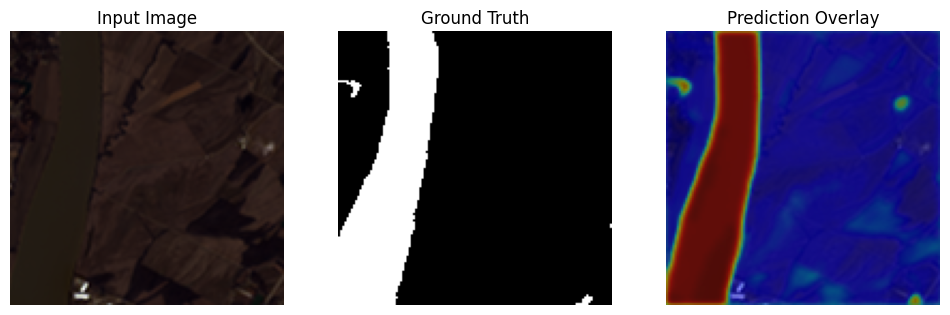

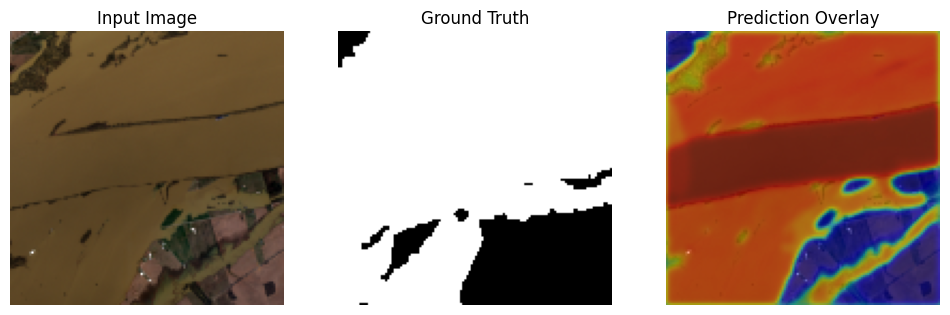

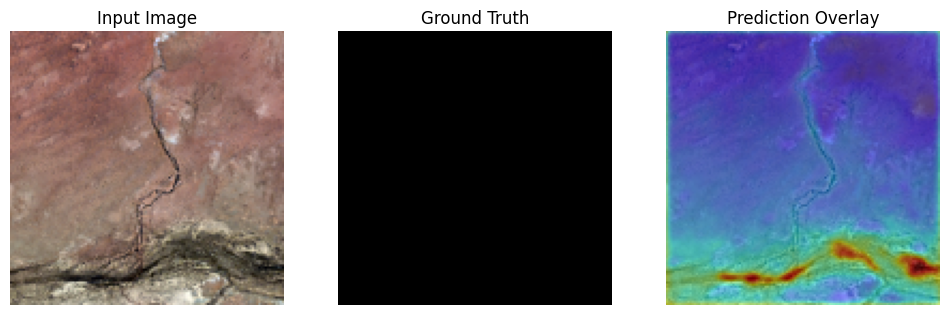

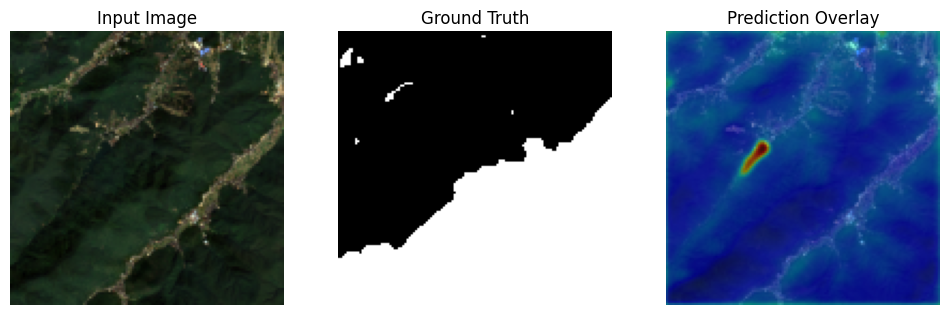

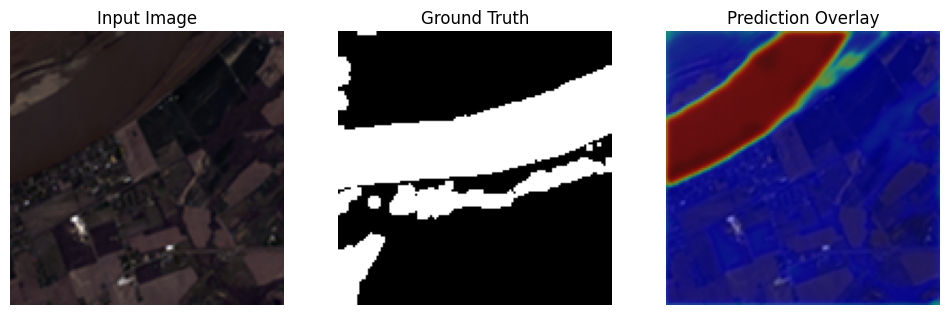

In [50]:
def overlay_predictions(model, generator, alpha=0.5, num_samples=3):
    # Get one batch
    images, masks = next(iter(generator))
    predictions = model.predict(images)

    for i in range(min(num_samples, len(images))):
        img = images[i]

        # If 12-band, select 3 bands (e.g., bands 3, 2, 1) for visualization
        if img.shape[-1] == 12:
            img_vis = img[..., [3, 2, 1]]  # Use near-infrared/RGB
        else:
            img_vis = img

        plt.figure(figsize=(12, 6))

        plt.subplot(1, 3, 1)
        plt.title("Input Image")
        plt.imshow(img_vis)
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title("Ground Truth")
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title("Prediction Overlay")
        plt.imshow(img_vis)
        plt.imshow(predictions[i].squeeze(), cmap='jet', alpha=alpha)
        plt.axis('off')

        plt.show()
overlay_predictions(model, val_generator, alpha=0.5, num_samples=5)
